Bear with me: MNIST is where everyone in machine learning starts, but I hope this tutorial is different from the others out there.

Back when TensorFlow was released to the public in November 2015, I remember following TensorFlow’s beginner MNIST tutorial. I blindly copied and pasted all this code into my terminal and some numbers popped out as they should have. I thought, OK, I know there is something amazing happening here, why can I not see it? My goal was to make a MNIST tutorial that was both interactive and visual, and hopefully will teach you a thing or two that others just assume you know.

In this tutorial, I will be using the machine learning library TensorFlow with Python3 on Ubuntu 14.04. If you need help installing TensorFlow on your own system check out my tutorial here.

If you don't have numpy and matplotlib installed, you’ll need them. Open a terminal and type in:

<img src="Images/Total_Network.jpg">

To begin, we will open up python in our terminal and import the MNIST data set:

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import random as ran

To begin, we will open up python in our terminal and import the MNIST data set:

<img src="Images/mnist_plot-800x600.png">

In [30]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


First, let’s define a couple of functions that will assign the amount of training and test data we will load from the data set. It’s not vital to look very deeply at these unless you want to figure out what’s going on behind the scenes.

You will need to copy and paste each function and hit enter twice in your terminal:

In [31]:
def TRAIN_SIZE(num):
    print ('Total Training Images in Dataset = ' + str(mnist.train.images.shape))
    print ('--------------------------------------------------')
    x_train = mnist.train.images[:num,:]
    print ('x_train Examples Loaded = ' + str(x_train.shape))
    y_train = mnist.train.labels[:num,:]
    print ('y_train Examples Loaded = ' + str(y_train.shape))
    print('')
    return x_train, y_train

def TEST_SIZE(num):
    print ('Total Test Examples in Dataset = ' + str(mnist.test.images.shape))
    print ('--------------------------------------------------')
    x_test = mnist.test.images[:num,:]
    print ('x_test Examples Loaded = ' + str(x_test.shape))
    y_test = mnist.test.labels[:num,:]
    print ('y_test Examples Loaded = ' + str(y_test.shape))
    return x_test, y_test

And we’ll define some simple functions for resizing and displaying the data:

In [32]:
def display_digit(num):
    print(y_train[num])
    label = y_train[num].argmax(axis=0)
    image = x_train[num].reshape([28,28])
    plt.title('Example: %d  Label: %d' % (num, label))
    plt.imshow(image, cmap=plt.get_cmap('gray_r'))
    plt.show()

def display_mult_flat(start, stop):
    images = x_train[start].reshape([1,784])
    for i in range(start+1,stop):
        images = np.concatenate((images, x_train[i].reshape([1,784])))
    plt.imshow(images, cmap=plt.get_cmap('gray_r'))
    plt.show()

Now, we’ll get down to the business of building and training our model. First, we define variables with how many training and test examples we would like to load. For now, we will load all the data but we will change this value later on to save resources:

In [33]:
x_train, y_train = TRAIN_SIZE(5500)

Total Training Images in Dataset = (55000, 784)
--------------------------------------------------
x_train Examples Loaded = (5500, 784)
y_train Examples Loaded = (5500, 10)



So, what does this mean? In our data set, there are 55,000 examples of handwritten digits from zero to nine. Each example is a 28x28 pixel image flattened in an array with 784 values representing each pixel’s intensity. The examples need to be flattened for TensorFlow to make sense of the digits linearly. This shows that in x_train we have loaded 55,000 examples each with 784 pixels. Our x_train variable is a 55,000 row and 784 column matrix.

The y_train data is the associated labels for all the x_train examples. Rather than storing the label as an integer, it is stored as a 1x10 binary array with the one representing the digit. This is also known as one-hot encoding. In the example below, the array represents a 7:

So, let’s pull up a random image using one of our custom functions that takes the flattened data, reshapes it, displays the example, and prints the associated label (note: you have to close the window matplot opens to continue using Python):

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


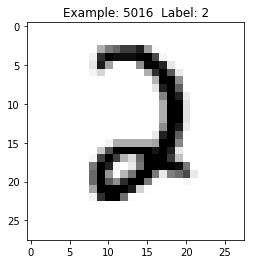

In [36]:
display_digit(ran.randint(0, x_train.shape[0]))

Some description about we flatten the images


<img src="Images/Image_Flattening.jpg">

Here is what multiple training examples look like to the classifier in their flattened form. Of course, instead of pixels, our classifier sees values from zero to one representing pixel intensity:

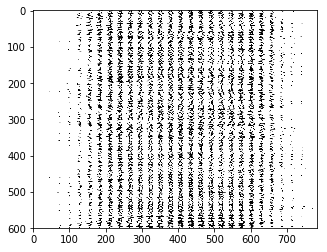

In [38]:
display_mult_flat(400,1000)

Until this point, we actually have not been using TensorFlow at all. The next step is importing TensorFlow and defining our session. TensorFlow, in a sense, creates a directed acyclic graph (flow chart) which you later feed with data and run in a session:

In [39]:
import tensorflow as tf
sess = tf.Session()

Next, we can define a placeholder. A placeholder, as the name suggests, is a variable used to feed data into. The only requirement is that in order to feed data into this variable, we need to match its shape and type exactly. The TensorFlow website explains that “A placeholder exists solely to serve as the target of feeds. It is not initialized and contains no data.” Here, we define our x placeholder as the variable to feed our x_train data into:

<img src="Images/Model_Details.jpg">

In [41]:
x = tf.placeholder(tf.float32, shape=[None, 784])

When we assign None to our placeholder, it means the placeholder can be fed as many examples as you want to give it. In this case, our placeholder can be fed any multitude of 784-sized values.

We then define y_, which will be used to feed y_train into. This will be used later so we can compare the ground truths to our predictions. We can also think of our labels as classes:

In [42]:
y_ = tf.placeholder(tf.float32, shape=[None, 10])

Next, we will define the weights W and bias b. These two values are the grunt workers of the classifier—they will be the only values we will need to calculate our prediction after the classifier is trained.

We will first set our weight and bias values to zeros because TensorFlow will optimize these values later. Notice how our W is a collection of 784 values for each of the 10 classes:

In [43]:
W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))

I like to think of these weights as 10 cheat sheets for each number. This is similar to how a teacher uses a cheat sheet transparency to grade a multiple choice exam. The bias, unfortunately, is a little beyond the scope of this tutorial, but I like to think of it as a special relationship with the weights that influences our final answer.

We will now define y, which is our classifier function. This particular classifier is also known as multinomial logistic regression. We make our prediction by multiplying each flattened digit by our weight and then adding our bias:

In [44]:
y = tf.nn.softmax(tf.matmul(x,W) + b)

First, let’s ignore the softmax and look what's inside the softmax function. Matmul is the function for multiplying matrices. If you know your matrix multiplication, you would understand that this computes properly and that x * W + b results in a Number of Training Examples Fed (m) x Number of Classes (n) matrix.

If you don’t believe me, you can confirm it by evaluating y:

In [45]:
print(y)

Tensor("Softmax_3:0", shape=(?, 10), dtype=float32)


That tells us what y is in our session, but what if we want the values of y? You cannot just print a TensorFlow graph object to get its values; you must run an appropriate session in which you feed it data. So, let’s feed our classifier three examples and see what it predicts. In order to run a function in our session, we first must initialize the variables in our session. Notice if you just run sess.run(y) TensorFlow will complain that you need to feed it data:

In [47]:
x_train, y_train = TRAIN_SIZE(7)
sess.run(tf.global_variables_initializer())
#If using TensorFlow prior to 0.12 use:
#sess.run(tf.initialize_all_variables())
print(sess.run(y, feed_dict={x: x_train}))

Total Training Images in Dataset = (55000, 784)
--------------------------------------------------
x_train Examples Loaded = (7, 784)
y_train Examples Loaded = (7, 10)

[[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]]


So, here we can see our prediction for our first three training examples. Of course, our classifier knows nothing at this point, so it outputs an equal 10% probability of our training examples for each possible class.

But how did TensorFlow know the probabilities, you might ask; it learned the probabilities by calculating the softmax of our results. The Softmax function takes a set of values and forces their sum to equal one, which will give probabilities for each value. Any softmax value will always be greater than zero and less than one. Still confused? Try running this or read up on what softmax is doing mathematically:

In [48]:
sess.run(tf.nn.softmax(tf.zeros([4])))

array([0.25, 0.25, 0.25, 0.25], dtype=float32)

In [49]:
sess.run(tf.nn.softmax(tf.constant([0.1, 0.005, 2])))

array([0.11634309, 0.10579926, 0.7778576 ], dtype=float32)

Next, we will create our cross_entropy function, also known as a loss or cost function. It measures how good (or bad) of a job we are doing at classifying. The higher the cost, the higher the level of inaccuracy. It calculates accuracy by comparing the true values from y_train to the results of our prediction y for each example. The goal is to minimize your loss:

In [50]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
# cross_entropy = -tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1])

This function is taking the log of all our predictions y (whose values range from 0 to 1) and element wise multiplying by the example’s true value y_. If the log function for each value is close to zero, it will make the value a large negative number (i.e., -np.log(0.01) = 4.6), and if it is close to 1, it will make the value a small negative number (i.e., -np.log(0.99) = 0.1).

We are essentially penalizing the classifier with a very large number if the prediction is confidently incorrect and a very small number if the prediction is confidendently correct.

Here is a simple made up python example of a softmax prediction that is very confident that the digit is a 3:

In [18]:
j = [0.03, 0.03, 0.01, 0.9, 0.01, 0.01, 0.0025,0.0025, 0.0025, 0.0025]

Let’s create an array label of "3" as a ground truth to compare to our softmax function:

In [51]:
k = [0,0,0,1,0,0,0,0,0,0]

Can you guess what value our loss function gives us? Can you see how the log of “j” would penalize a wrong answer with a large negative number? Try this to understand:

In [52]:
-np.log(j)
-np.multiply(np.log(j),k)

array([0.        , 0.        , 0.        , 0.10536052, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

This will return nine zeros and a value of 0.1053, which when all summed up, we would consider a good prediction. Notice what happens when we make the same prediction for what is actually a 2:

In [54]:
k = [0,0,1,0,0,0,0,0,0,0]
np.sum(-np.multiply(np.log(j),k))

4.605170185988091

Now, our cross_entropy function gives us 4.6051, which shows a heavily penalized, poorly made prediction. It was heavily penalized due to the fact the classifier was very confident that it was a 3 when it actually was a 2.

Next we begin to train our classifier. In order to train, we have to develop appropriate values for W and b that will give us the lowest possible loss.

Below is where we can now assign custom variables for training if we wish. Any value that is in all caps below is designed to be changed and messed with. In fact, I encourage it! First, use these values, then later notice what happens when you use too few training examples or too high or low of a learning rate.

If you set TRAIN_SIZE to a large number, be prepared to wait for a while. At any point, you can re run all the code starting from here and try different values:

In [55]:
x_train, y_train = TRAIN_SIZE(5500)
x_test, y_test = TEST_SIZE(10000)
LEARNING_RATE = 0.1
TRAIN_STEPS = 2500

Total Training Images in Dataset = (55000, 784)
--------------------------------------------------
x_train Examples Loaded = (5500, 784)
y_train Examples Loaded = (5500, 10)

Total Test Examples in Dataset = (10000, 784)
--------------------------------------------------
x_test Examples Loaded = (10000, 784)
y_test Examples Loaded = (10000, 10)


We can now initialize all variables so that they can be used by our TensorFlow graph:

In [56]:
init = tf.global_variables_initializer()
#If using TensorFlow prior to 0.12 use:
#init = tf.initialize_all_variables()
sess.run(init)

Now, we need to train our classifier using gradient descent. We first define our training method and some variables for measuring our accuracy. The variable training will perform the gradient descent optimizer with a chosen LEARNING_RATE in order to try to minimize our loss function cross_entropy:

In [57]:
training = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Now, we’ll define a loop that repeats TRAIN_STEPS times; for each loop, it runs training, feeding in values from x_train and y_train using feed_dict. In order to calculate accuracy, it will run accuracy to classify the unseen data in x_test by comparing its y and y_test. It is vitally important that our test data was unseen and not used for training data. If a teacher were to give students a practice exam and use that same exam for the final exam, you would have a very biased measure of students’ knowledge:

In [58]:
weight = sess.run(W)
W_List = [weight]
interested_In_Weights_For_Number = 3
for i in range(TRAIN_STEPS+1):
    sess.run(training, feed_dict={x: x_train, y_: y_train})
    if i%100 == 0:
        print('Training Step:' + str(i) + '  Accuracy =  ' + str(sess.run(accuracy, feed_dict={x: x_test, y_: y_test})) + '  Loss = ' + str(sess.run(cross_entropy, {x: x_train, y_: y_train})))
        weight = sess.run(W)
        W_List.append(weight)
#         plt.figure()
#         weight = sess.run(W)[:,interested_In_Weights_For_Number]
#         plt.imshow(weight.reshape([28,28]))#, cmap=plt.get_cmap('seismic'))
#         _ = input("Press [enter] to continue.")
        
        

        

Training Step:0  Accuracy =  0.5988  Loss = 2.1881988
Training Step:100  Accuracy =  0.8647  Loss = 0.5802968
Training Step:200  Accuracy =  0.879  Loss = 0.45982155
Training Step:300  Accuracy =  0.8866  Loss = 0.40857217
Training Step:400  Accuracy =  0.8904  Loss = 0.37808105
Training Step:500  Accuracy =  0.8943  Loss = 0.3569754
Training Step:600  Accuracy =  0.8974  Loss = 0.34104994
Training Step:700  Accuracy =  0.8984  Loss = 0.32834953
Training Step:800  Accuracy =  0.9  Loss = 0.31782654
Training Step:900  Accuracy =  0.9005  Loss = 0.30886242
Training Step:1000  Accuracy =  0.9009  Loss = 0.30106455
Training Step:1100  Accuracy =  0.9023  Loss = 0.29417014
Training Step:1200  Accuracy =  0.9029  Loss = 0.28799504
Training Step:1300  Accuracy =  0.9033  Loss = 0.2824061
Training Step:1400  Accuracy =  0.9039  Loss = 0.27730304
Training Step:1500  Accuracy =  0.9048  Loss = 0.2726099
Training Step:1600  Accuracy =  0.9057  Loss = 0.26826677
Training Step:1700  Accuracy =  0.9

Now let's see the weights revolution

In [59]:
import numpy as np
import matplotlib.pyplot as plt

def showItAll(number_of_Iterations, W_List):
    w=28
    h=28
    fig=plt.figure(figsize=(28, 28))
    columns = 10
    rows = number_of_Iterations
    for row_index in range(number_of_Iterations):
        temp_W = W_List[row_index]
        for col_index in range (10):
            weight = temp_W[:,col_index]
            img = weight.reshape([28,28])
            i = 10*row_index + col_index + 1
            fig.add_subplot(rows, columns, i)
            plt.imshow(img, cmap=plt.get_cmap('seismic'))
    plt.show()
        
    

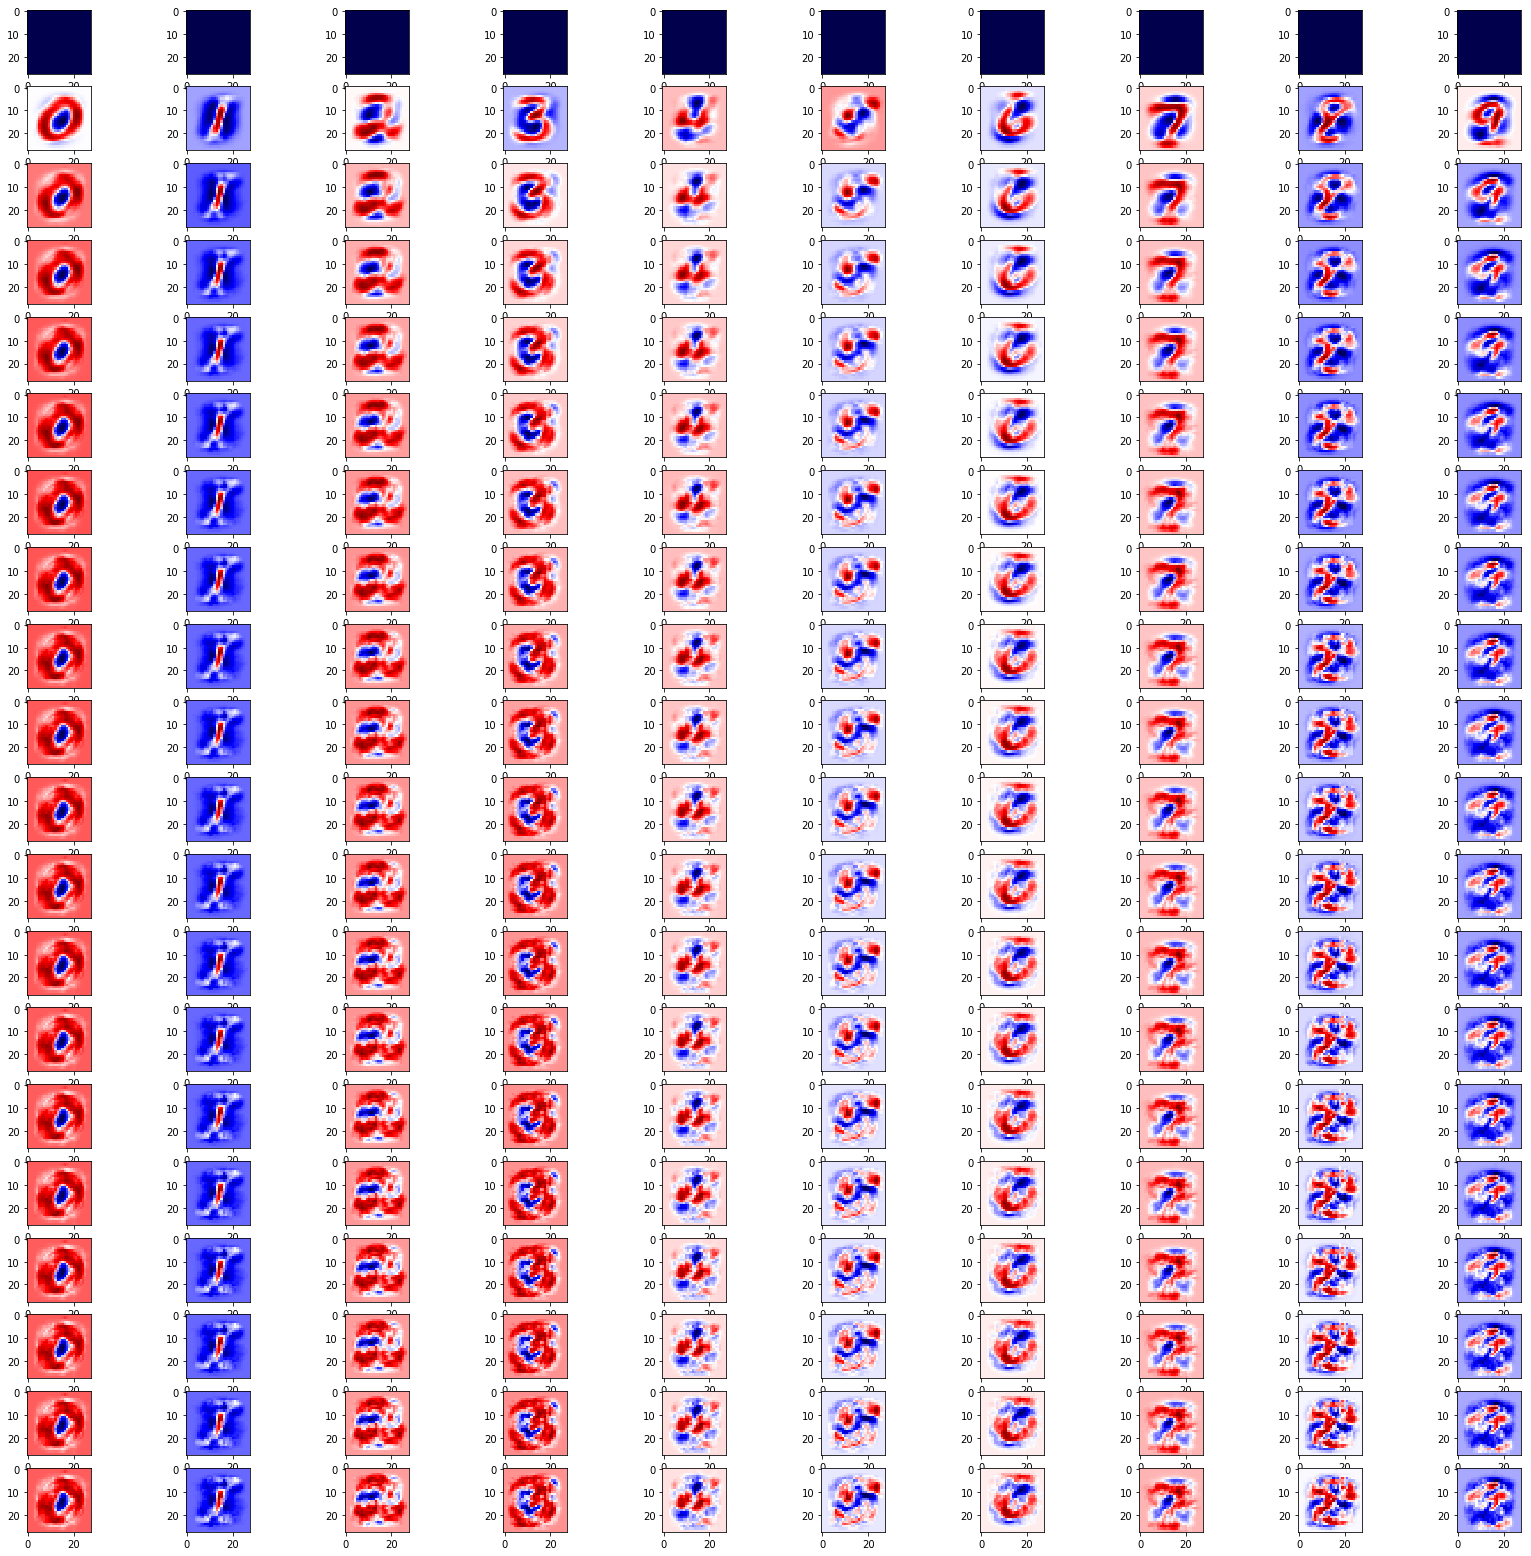

In [60]:
number_of_Iterations = 20
showItAll(number_of_Iterations, W_List)

In order to visualize what gradient descent is doing, you have to imagine the loss as being a 784 dimensional graph based on y_ and y, which contains different values of x, W, and b. If you can’t visualise 784 dimensions, that’s to be expected. I highly recommend Chris Olah’s blog to learn more amount the dimensions involved with MNIST. To explain things more simply in two-dimensions, we will use y = x^2:

For each step in the loop, depending on how large the cross_entropy is the classifier will move a LEARNING_RATE step toward where it thinks cross_entropy’s value will be smaller. This lower point is calculated by TensorFlow using the derivative of the cross_entropy, which gives the slope of the tangent line at a given point. As it moves toward this new point, the values W and b change and the slope decreases. As in the case of y = x^2, you can think of this as moving toward X = 0, which is also called the minimum. If the learning rate is too small, the classifier will take very small steps when learning; if it's too high, the steps it takes will be too large, and it may figuratively “overshoot” the true minimum.

Notice how near the end, the loss was still decreasing but our accuracy slightly went down? This shows that we could still minimize our loss on our training data, but this may not help us predict the unseen testing data used for measuring accuracy. This is also known as overfitting (not generalizing). With the default settings, I got an accuracy of about 91%. If I wanted to cheat to get 94% accuracy, I could set the test examples to 100. This shows how not having enough test examples can give you a biased sense of accuracy.

Keep in mind this a very ineffective way to calculate our classifier. But I did this on purpose for the sake of learning and experimentation. Ideally, when training with large data sets, you train using small batches of training data at a time, not all at once. If you would like to learn how to do this, follow the tutorial on TensorFlow’s website.

This is my favorite part. Now that we have calculated our weight cheatsheet, we can create a graph with the following code:

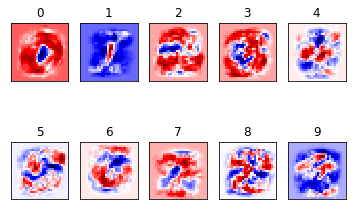

In [26]:
for i in range(10):
    plt.subplot(2, 5, i+1)
    weight = sess.run(W)[:,i]
    plt.title(i)
    plt.imshow(weight.reshape([28,28]), cmap=plt.get_cmap('seismic'))
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)

Now let’s visualize it:

In [27]:
plt.show()

This is a visualization of our weights from 0-9. This is the most important aspect of our classifier. The bulk of the work of machine learning is figuring out what the optimal weights are; once they are calculated, you have the “cheat sheet” and can easily find answers. (This is part of why neural networks can be readily ported to mobile devices; the model, once trained, doesn’t take up that much room to store or computing power to calculate.) Our classifier makes its prediction by comparing how similar or different the digit is to the red and blue. I like to think the darker the red, the better of a hit; white as neutral; and blue as misses.

So, now that we have our cheat sheet, let’s load one example and apply our classifier to that one example:

Total Training Images in Dataset = (55000, 784)
--------------------------------------------------
x_train Examples Loaded = (1, 784)
y_train Examples Loaded = (1, 10)

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


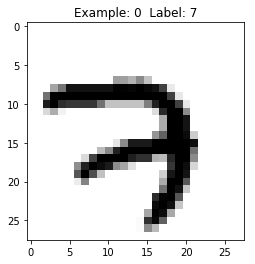

In [28]:
x_train, y_train = TRAIN_SIZE(1)
display_digit(0)

Let’s look at our predictor y:

In [29]:
answer = sess.run(y, feed_dict={x: x_train})
print(answer)

[[2.12480318e-05 1.16469255e-05 8.96317363e-02 1.92015301e-02
  8.20864516e-04 1.25168317e-05 3.85382300e-05 8.53746057e-01
  6.91889180e-03 2.95969769e-02]]


This gives us a (1x10) matrix with each column containing one probability:

But this is not very useful for us. So, we use the argmax function to return the position of the highest value and that gives us our prediction.

In [30]:
answer.argmax()

7

So, let us now take our knowledge to create a function to make predictions on a random digit in this data set:

In [31]:
def display_compare(num):
    # THIS WILL LOAD ONE TRAINING EXAMPLE
    x_train = mnist.train.images[num,:].reshape(1,784)
    y_train = mnist.train.labels[num,:]
    # THIS GETS OUR LABEL AS A INTEGER
    label = y_train.argmax()
    # THIS GETS OUR PREDICTION AS A INTEGER
    prediction = sess.run(y, feed_dict={x: x_train}).argmax()
    plt.title('Prediction: %d Label: %d' % (prediction, label))
    plt.imshow(x_train.reshape([28,28]), cmap=plt.get_cmap('gray_r'))
    plt.show()

And now try the function out:

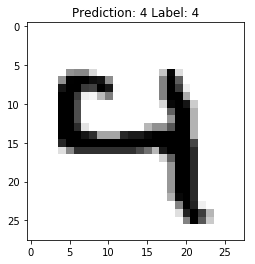

In [32]:
display_compare(ran.randint(0, 55000))

Can you find any that guessed incorrectly? If you enter display_compare(2), you will find one digit the classifier got wrong. Why do you think it got it wrong?

This is where this tutorial gets fun: notice what happens to the visualizations of the weights when you use 1-10 training examples. It becomes clear that using too little data makes it very hard to generalize. Here is a animation showing how the weights change as you increase your training size. Can you see what is happening?

You can also see the limitations of a linear classifier; at a certain point, feeding it more data doesn’t help increase your accuracy drastically. What do you think would happen if we tried to classify a “1” that was drawn on the very left side of the square? It would have a very hard time classifying it because in all of its training examples, the 1 was very close to the center.

I hope this helps make you more appreciative to know just how much is going on behind the scenes in MNIST. Keep in mind that this a neural network with two layers; it’s not deep learning. In order to get close to near-perfect accuracy, we have to start thinking convolutionally deep.

If you would prefer to run a more interactive session, here is my GitHub repo with the Jupyter Notebook version of this. I had a lot of fun writing this and learning along the way. Thanks for reading, and most of all, I really hope something new clicked in your brain today.